# Прогнозирование заказов такси 

## Цель проекта:

Разработать модель прогнозирования количества заказов такси на следующий час на основании исторических данных о заказах такси в аэропортах. 

Метрика качества - RMSE, значение метрики должно быть меньше 48.

### Библиотеки

In [1]:
import time

import pandas as pd

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb

# 0. Предварительный взгляд на данные

In [2]:
# taxi_time_ser = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
taxi_time_ser = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])
taxi_time_ser

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
taxi_time_ser.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


26+ тысяч значений. Пропусков сходу не видно. У нас в наличии значения с 1 марта по 31 августа 2018 года. Уточним - когда отсортируем. 

Значения целевого признака - количественные, стало быть перед нами задача регрессии. Отлично.

Теперь к данным!

# 1-2. Подготовка и анализ данных

Проверим временной ряд на монотонность.

In [4]:
print(taxi_time_ser.index.is_monotonic)

True


Супер, ничего переставлять местами не нужно. У нас точно 6 месяцев значений. 

Посмотрим на распределение значений целевого признака - для общего развития.

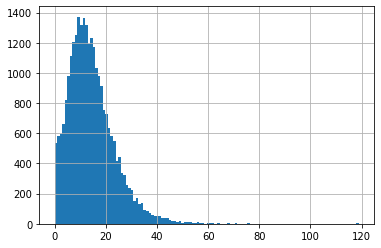

In [5]:
taxi_time_ser['num_orders'].hist(bins = 120)

Перед нами нормальное распределение с крайне длинным "хвостом" справа - в сторону повышенных значений. Звучит (и выглядит) весьма "статистически" :) В другой ситуации "хвосту" бы не поздоровилось - но не в нашем случае. Временной ряд, все-таки.

Ресемплируем с масштабом в 1 час.

In [6]:
taxi_hour = taxi_time_ser.resample('1H').mean()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025EBD6136C8>]],
      dtype=object)

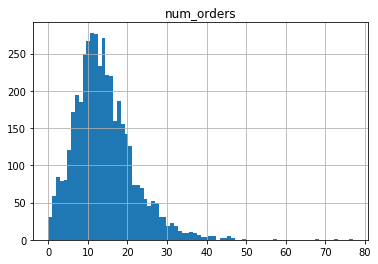

In [7]:
taxi_hour.hist(bins = 80)

Ресемплирование на 1 час по среднему значению, наверняка не привело к изменению среднего значений (ведь среднее средних - тоже самое, по итогу), хотя размах распределения, очевидно изменился. 

Построим временной ряд.

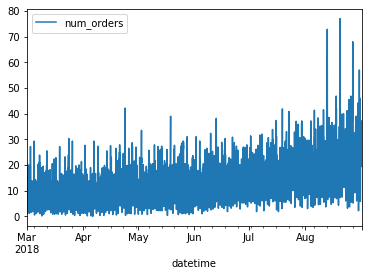

In [8]:
taxi_hour.plot()

Хотел тут написать про нестационарность ряда и т.п., но перед этим, пожалуй, убедимся в этом с помощью разделения на сезонность, тренд и шум.

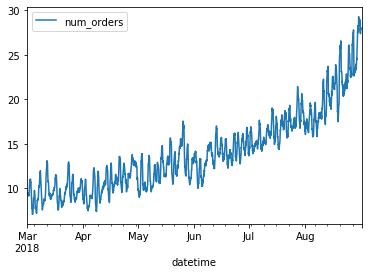

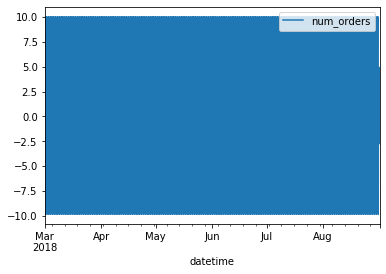

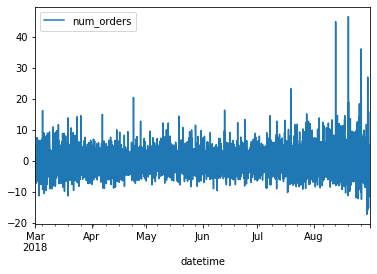

In [9]:
decomposed = seasonal_decompose(taxi_hour)
decomposed.trend.plot()
decomposed.seasonal.plot()
decomposed.resid.plot() 

Тренд на повышение числа заявок на такси к лету очевиден и неоспорим. Сезонность пролетает "мимо", вероятно, в связи с недостаточным объемом данных - у нас всего полгода. А в меньшем масштабе мы и не смотрим.

И тем не менее, перед нами нестационарный временной ряд - среднее меняется в зависимости от времени, впрочем как и стандартное отклонение.

Напишем функцию для подготовки данных и вычленения признаков. Воспользуемся кодом, который мы писали в тренажере. Он вполне подойдет. Здесь нам предстоит найти некий промежуточный вариант между количеством признаков, длительностью обучения, сложностью модели и значением целевой метрики. 

Но сперва - функция "создания признаков".

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)
    
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new.dropna()

Функция готова, воспользуемся ей в разделе "обучение".

# 3. Обучение

Сравнивать с целью получения наилучшего значения метрики будем модели 2 типов - градиентный бустинг на деревьях и обычную линейную регрессию. Бустинг - на майкрософтовском LGBM.

Обучение моделей будем проводить на 4 датасетах - этого, на мой взгляд, будет достаточно, чтобы как минимум предположить направление изменения значения метрики, в зависимости от числа "лагов" и размера скользящей рамки.

1. Лаг = 3, рамка = 4
2. Лаг = 8, рамка = 4
3. Лаг = 3, рамка = 10
4. Лаг = 8, рамка = 10

Нарежем датасетов с соответствующими номерами для последующего обучения.

In [11]:
taxi_f1 = make_features(taxi_hour, 3, 4)
taxi_f2 = make_features(taxi_hour, 8, 4)
taxi_f3 = make_features(taxi_hour, 3, 10)
taxi_f4 = make_features(taxi_hour, 8, 10)

print(taxi_f1.shape, taxi_f2.shape, taxi_f3.shape, taxi_f4.shape)

(4412, 9) (4408, 14) (4406, 9) (4406, 14)


Думаю я, думаю и никак не могу понять - стоит ли в данном случае делать валидационную выборку, на основании которой я смогу определять наилучшую модель, с точки зрения метрики RMSE. 

И я придумал следующий план. Да, валидационная выборка нужна. Она составит ещё 10% от общего объема данных, следовательно итоговое соотношение train-valid-test будет равно 80-10-10. После подбора гиперпараметров лучшей модели и перехода к тестированию, я повторно обучу модель с лучшими гиперпараметрами на выборке train+valid, тем самым не потеряв никаких данных.

А поскольку нам по такой логике предстоит ещё делить датасеты на признаки и целевой признак, а также на train-valid-test, напишем функцию, автоматизирующую сам процесс.

In [12]:
def train_valid_test_ft(data, target_name, valid_size, test_size):
    
    data_features = data.drop([target_name], axis = 1)
    data_target = data[target_name]
    
    vt_size = valid_size + test_size
    
    (features_train, features_valid_test,
     target_train, target_valid_test) = train_test_split(data_features, data_target, 
                                                         test_size = vt_size, shuffle = False)
    ratio = test_size / vt_size
    
    (features_valid, features_test,
     target_valid, target_test) = train_test_split(features_valid_test, target_valid_test, 
                                                   test_size = ratio, shuffle = False)
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

"Разделом" датасетов будем заниматься непосредственно перед обучением моделей. А пока выставим параметры LightGBM.

### LightGBM - градиентный бустинг на деревьях

Модель взял из предшествующего проекта.

In [13]:
def model_parameters(data, depth, l_rate, leaves):
    
    evals_result = {}
    parameters_gbdt = {'objective': 'regression',
                       'metric': 'rmse',
                       'boosting': 'gbdt',
                        'num_leaves': leaves,
                        'device_type' : 'cpu',
                        'num_threads' : 8,
                        'force_row_wise' : True,
                        'learning_rate' : l_rate,
                        'max_depth' : depth
                      }
    
    start_time = time.time()
    
    (features_train, features_valid,
     features_test, target_train,
     target_valid, target_test) = train_valid_test_ft(data, 'num_orders', 0.1, 0.1)
    
    train_data = lgb.Dataset(features_train, label = target_train, free_raw_data = False)
    valid_data = lgb.Dataset(features_valid, label = target_valid, free_raw_data = False)
    
    best_model = lgb.train(parameters_gbdt, train_data, 5000,
                               valid_sets = valid_data, early_stopping_rounds = 20,
                               evals_result = evals_result,
                               verbose_eval = False
                              )
    worktime = time.time() - start_time
    iterations = best_model.best_iteration
    rmse = best_model.best_score['valid_0']['rmse']

    return worktime, iterations, rmse

Приступим. Начнем с первого датасета.

Теперь подбираем гиперпараметры. Функцию я также "приватизировал" из прошлого проекта.

In [14]:
def hyper_finder(data, bottom_d, top_d, step_d, bottom_r, top_r, step_r):
    
    final_table = pd.DataFrame(data = [], columns = ['max_depth', 'learning_rate', 'leaves_num',
                                                     'iterations', 'time, s', 'rmse'])
    i = 0
    
    for depth in range(bottom_d, top_d + 1, step_d):
        for rate in range(bottom_r, top_r + 1, step_r):
               
                
            max_depth = depth
            learning_rate = float(rate / 100)
                
            worktime, iterations, rmse = model_parameters(data, max_depth, learning_rate, 31)
            
            final_table.loc[i, 'max_depth'] = max_depth
            final_table.loc[i, 'learning_rate'] = learning_rate
            final_table.loc[i, 'iterations'] = iterations
            final_table.loc[i, 'leaves_num'] = 31
            final_table.loc[i, 'time, s'] = worktime
            final_table.loc[i, 'rmse'] = rmse
            i += 1
            
    return final_table.sort_values(by=['rmse'])

In [15]:
%%time
hyper_finder(taxi_f1, 2, 52, 5, 5, 35, 5)[:5]

Wall time: 14.3 s


,max_depth,learning_rate,leaves_num,iterations,"time, s",rmse
1,2,0.1,31,218,0.156581,6.87601
2,2,0.15,31,196,0.158577,6.87885
0,2,0.05,31,429,0.213427,6.88782
4,2,0.25,31,74,0.135639,6.89834
5,2,0.3,31,57,0.0977404,6.91546


In [16]:
%%time
f1_results = hyper_finder(taxi_f1, 2, 7, 1, 5, 15, 1)[:5]
f1_results

Wall time: 13 s


,max_depth,learning_rate,leaves_num,iterations,"time, s",rmse
5,2,0.1,31,218,0.158801,6.87601
10,2,0.15,31,196,0.148012,6.87885
20,3,0.14,31,93,0.134981,6.88393
1,2,0.06,31,369,0.235371,6.88497
13,3,0.07,31,222,0.251926,6.88614


UPD. 

Я тут обнаружил, что для имеющихся данных при использовании модели градиентного бустинга, наблюдаются "перепады" в значениях гиперпараметров для "лучшей" метрики. Поэтому, я решил оставить оценку модели только с точки зрения RMSE. Да, время - второй после точности (а в некоторых случаях и первый) критерий "успешности" модели. Однако, поскольку у нас наблюдается "нестабильность" времени выполнения кода - по неизвестной мне причине, я принял решение "стабилизироваться" за счет RMSE. Такие дела.

Проверим, как влияют на значение RMSE число листьев у модели. Функцию подбора я также взял из предшествующего проекта.

In [17]:
def leaf_finder(data, depth, l_rate, bottom, top, step):
    final_table = pd.DataFrame(data = [], columns = ['max_depth', 'learning_rate', 'leaves_num',
                                                     'iterations', 'time, s', 'rmse'])
    i = 0
    
    for leaf in range(bottom, top+1, step):
         
            worktime, iterations, rmse = model_parameters(data, depth, l_rate, leaf)

            final_table.loc[i, 'max_depth'] = depth
            final_table.loc[i, 'learning_rate'] = l_rate
            final_table.loc[i, 'leaves_num'] = leaf
            final_table.loc[i, 'iterations'] = iterations
            final_table.loc[i, 'time, s'] = worktime
            final_table.loc[i, 'rmse'] = rmse
            i += 1
            
    return final_table.sort_values(by=['rmse'])

In [18]:
%%time
f1_results_leaf = leaf_finder(taxi_f1, 
                              f1_results.iloc[0,0],
                              f1_results.iloc[0,1],
                              31, 331, 10)[:5]
f1_results_leaf

Wall time: 4.8 s


,max_depth,learning_rate,leaves_num,iterations,"time, s",rmse
0,2,0.1,31,218,0.159976,6.87601
28,2,0.1,311,218,0.185523,6.87601
27,2,0.1,301,218,0.16855,6.87601
26,2,0.1,291,218,0.139627,6.87601
25,2,0.1,281,218,0.136634,6.87601


Как выяснилось, значение RMSE в нашем случае не зависит от числа "листочков". Время - да, но не RMSE. А учитывая, что время обучения-работы модели составляет порядка 0.1 секунды (в рамках "анаконды" на личном ПК) + крайне сильно "колеблется" в зависимости от внешних условий (каких именно - я пока не выяснил) + текст, приведенный выше в UPD., на этот критерий в нашем случае я не обращаю внимания. Специально.

Учитывая, что нам предстоит работать с 4-мя датасетами, чтобы сократить число ячеек и "ручной работы", напишем функцию, которая соберет в конечную таблицу гиперпараметры ЛУЧШИХ с точки зрения RMSE моделей.

На выходе мы получим таблицу из 4 строчек, содержащую гиперпараметры моделей + значения RMSE моделей, обученных на различных датасетах. Так мы сможем установить влияние размера "скользящего окна", а также "предшествующих значений" на потенциальную точность прогнозирования временных рядов с помощью ML.

In [19]:
def feature_tester(data_list, bottom_d, top_d, step_d, bottom_r, top_r, step_r):
    
    bottom_d_new = 0
    top_d_new = 0
    step_d_new = 0
    bottom_r_new = 0 
    top_r_new = 0
    step_r_new = 0
    
#     диапазон "поиска значений гиперпараметров" у всех датасетов одинаковый
    ready = pd.DataFrame(data = [])
    
    for i, feature_set in enumerate(data_list):
        results_1 = hyper_finder(feature_set, bottom_d, top_d, step_d, bottom_r, top_r, step_r)[:1]
        
#         print(results_1)

#         Перемещаем "границу" поиска - проверяем крайнее нижнее условие

        if results_1.iloc[0, 0] == bottom_d:
            top_d_new = bottom_d + step_d
            bottom_d_new = bottom_d
        else:
            bottom_d_new = results_1.iloc[0, 0] - step_d
            top_d_new = results_1.iloc[0, 0] + step_d
            
        if results_1.iloc[0, 1] == bottom_r / 100:
            top_r_new = int(bottom_r + step_r)
            bottom_r_new = bottom_r
        else:
            bottom_r_new = int(results_1.iloc[0, 1] * 100 - step_r)
            top_r_new = int(results_1.iloc[0, 1] * 100 + step_r)
        
        step_d_new = 1
        step_r_new = 1
        
        results_2 = hyper_finder(feature_set, bottom_d_new, top_d_new, step_d_new, 
                                 bottom_r_new, top_r_new, step_r_new)[:1]
        ready = ready.append(results_2)
        
#         print(results_2)
   
    
    return ready.reset_index(drop = True)

In [20]:
%%time
f_list = [taxi_f1, taxi_f2, taxi_f3, taxi_f4]

feature_tester(f_list, 2, 52, 5, 5, 35, 5)

Wall time: 1min 40s


,max_depth,learning_rate,leaves_num,iterations,"time, s",rmse
0,2,0.1,31,218,0.178761,6.87601
1,29,0.09,31,110,0.324134,6.43532
2,3,0.34,31,37,0.0703971,6.96402
3,14,0.24,31,48,0.182028,6.46669


Готово. Но не до конца. Теперь, я вижу, что подбирать стоит не только гиперпараметры, но и способ создания признаков. Напишем новую функцию, которая найдет нам НАИЛУЧШИЙ способ "создания признаков". 

In [24]:
def features_create_finder(data, lag_bottom, lag_top, shape_bottom, shape_top):
    
    dict_lag_shape = {}
    f_list = []
    i = 0
    results = pd.DataFrame(data = [])
    
    for lag in range(lag_bottom, lag_top + 1, 1):
        for shape in range(shape_bottom, shape_top + 1, 1):
            dict_lag_shape[i] = str(lag) + '-' + str(shape)
            feature = make_features(data, lag, shape)
            f_list.append(feature)
                        
            i += 1
            
    results = feature_tester(f_list, 2, 52, 5, 5, 35, 5).sort_values(by = 'rmse')
    best_lag_shape = dict_lag_shape.get(int(results.index[0]))
           
    return best_lag_shape, results

In [25]:
%%time
results_gbdt = pd.DataFrame(data = [])
best_lag_shape, results_gbdt = features_create_finder(taxi_hour, 1, 5, 1, 5)

Wall time: 10min 35s


In [26]:
best_lag_shape

'5-2'

In [27]:
results_gbdt.head()

,max_depth,learning_rate,leaves_num,iterations,"time, s",rmse
21,2,0.27,31,93,0.126854,6.70667
22,8,0.1,31,50,0.186574,6.76629
23,2,0.34,31,69,0.115693,6.77279
17,3,0.17,31,73,0.133636,6.7736
18,3,0.29,31,72,0.132675,6.77948


Наименьшее значение RMSE получено для датасета со значением лага, равного 5 и рамки скользящего среднего в 2 единицы. Мы "уперлись" в потолок - нам необходимо расширить диапазон проверки для лага в сторону 5+. Для рамки, напротив, можем сократить диапазон вдвое - с 5 до 3. Сделаем это и посмотрим, что получилось.

In [28]:
%%time
results_gbdt = pd.DataFrame(data = [])
best_lag_shape_gbdt, results_gbdt = features_create_finder(taxi_hour, 5, 15, 1, 3)

Wall time: 24min 31s


In [29]:
best_lag_shape_gbdt

'14-2'

In [30]:
results_gbdt.head()

,max_depth,learning_rate,leaves_num,iterations,"time, s",rmse
28,9,0.1,31,191,0.500991,5.96087
31,9,0.1,31,88,0.401079,5.97252
32,9,0.09,31,145,0.634432,5.98767
29,12,0.1,31,102,0.284984,5.99542
23,5,0.17,31,86,0.198984,5.99978


Как мы видим, мы смогли ещё немного повысить точность прогнозирования, однако добиться этого удалось лишь путем почти 4 кратного повышения времени обучения и работы - с 0.1 до 0.4 секунд. Учитывая, что мозг человека может задерживать внимание примерно на 0.6 секунд на ЦВЕТНОМ (!) изображении, первый вариант выглядел несколько предпочительней. Хотя, конечно, здесь нужно уточнять вопрос у заказчика - что нам важнее - точность прогнозирования или сроки. Вероятно, если речь идет о прогнозировании спроса на такси - точность нам, всё же, важнее. Чего стоят несколько секунд компьюетрного времени и мощности в сравнении с 3 работниками, которые будут ВЫНУЖДЕНЫ остаться без заказов вследствие недостаточно точного прогнозирования? Правильно, ничего. Простой, почти всегда = убыткам. Следовательно, СЛЕДУЕТ двигаться далее в направлении повышения точности за счёт повышения числа ЛАГ-ПРИЗНАКОВ. Но этим будет заниматься кто-то другой. В рамках проекта нам более чем достаточно точности в 6 RMSE. 

Зафиксируем в финальной таблице и отправимся в "случайный лес".

In [31]:
test_table = pd.DataFrame(data = results_gbdt[:1]).reset_index(drop = True)
test_table['lag_shape'] = best_lag_shape_gbdt
test_table

,max_depth,learning_rate,leaves_num,iterations,"time, s",rmse,lag_shape
0,9,0.1,31,191,0.500991,5.96087,14-2


### Случайный лес

Составим функцию, которая позволит нам перебирать основные гиперпараметры, а также функцию, которая будет перебирать датасеты и находить лучшее сочетание датасет-гиперпараметры модели ML.

In [32]:
def rnd_forest_hyper(data, bottom_es, top_es, step_es, bottom_d, top_d, step_d):
    
    table = pd.DataFrame(data = [], columns = ['max_depth', 'estimators', 'time, s', 'rmse'])
    i = 0
    
    for estimators in range(bottom_es, top_es, step_es):
        for depth in range(bottom_d, top_d, step_d):
            
#             нарежем данные

            (features_train, features_valid,
             features_test, target_train, 
             target_valid, target_test) = train_valid_test_ft(data, 'num_orders', 0.1, 0.1)
            
            start_time = time.time()
    
            model = RandomForestRegressor(n_estimators = estimators, max_depth = depth, random_state = 11111)
            model.fit(features_train, target_train)
            
            pred_valid = model.predict(features_valid)
            rmse = mean_squared_error(target_valid, pred_valid) ** 0.5
            
            worktime = time.time() - start_time
            
            table.loc[i, 'max_depth'] = depth
            table.loc[i, 'estimators'] = estimators
            table.loc[i, 'time, s'] = worktime
            table.loc[i, 'rmse'] = rmse
            
#             print(i)
            
            i += 1
            
    return table.sort_values(by=['rmse'])

In [33]:
%%time
rnd_forest_hyper(taxi_f1, 2, 52, 5, 2, 52, 5).head()

Wall time: 35 s


,max_depth,estimators,"time, s",rmse
61,7,32,0.311478,7.11908
71,7,37,0.345077,7.13028
81,7,42,0.347072,7.13715
91,7,47,0.667215,7.14029
41,7,22,0.131725,7.16757


Функция работает. Теперь самое время подбирать НАИЛУЧШИЙ с точки зрения минимизации RMSE датасет.

In [34]:
def forest_feature_tester(data_list, bottom_es, top_es, step_es, bottom_d, top_d, step_d):
    
#     диапазон "поиска значений гиперпараметров" у всех датасетов одинаковый
    ready = pd.DataFrame(data = [])
    
    for i, feature_set in enumerate(data_list):
        results_1 = rnd_forest_hyper(feature_set, bottom_es, top_es, step_es, bottom_d, top_d, step_d)[:1]
        
#         print(results_1)

#         Перемещаем "границу" поиска - проверяем крайнее нижнее условие

        if results_1.iloc[0, 0] == bottom_d:
            top_d_new = bottom_d + step_d
            bottom_d_new = bottom_d
        else:
            bottom_d_new = results_1.iloc[0, 0] - step_d
            top_d_new = results_1.iloc[0, 0] + step_d
            
        if results_1.iloc[0, 1] == bottom_es:
            top_es_new = int(bottom_es + step_es)
            bottom_es_new = bottom_es
        else:
            bottom_es_new = results_1.iloc[0, 1] - step_es
            top_es_new = results_1.iloc[0, 1] + step_es
        
        step_d_new = 1
        step_es_new = 1
        
        results_2 = rnd_forest_hyper(feature_set, bottom_es_new, top_es_new, step_es_new,
                                     bottom_d_new, top_d_new, step_d_new)[:1]
        
        ready = ready.append(results_2)
#         print(results_2)
   
    
    return ready.reset_index(drop = True)

In [35]:
%%time
forest_feature_tester(f_list, 2, 52, 5, 2, 52, 5)

Wall time: 6min 47s


,max_depth,estimators,"time, s",rmse
0,7,34,0.282468,7.11296
1,20,51,1.72098,6.56678
2,8,44,0.254321,6.99156
3,47,45,1.14748,6.56868


Лучше? Лучше. Продолжаем.

In [36]:
def forest_features_create_finder(data, lag_bottom, lag_top, shape_bottom, shape_top):
    
    dict_lag_shape = {}
    f_list = []
    i = 0
    results = pd.DataFrame(data = [])
    
    for lag in range(lag_bottom, lag_top + 1, 1):
        for shape in range(shape_bottom, shape_top + 1, 1):
            dict_lag_shape[i] = str(lag) + '-' + str(shape)
            feature = make_features(data, lag, shape)
            f_list.append(feature)
                        
            i += 1
            
    results = forest_feature_tester(f_list, 2, 52, 5, 2, 52, 5).sort_values(by = 'rmse')
    best_lag_shape = dict_lag_shape.get(int(results.index[0]))
           
    return best_lag_shape, results

In [37]:
%%time
results_forest = pd.DataFrame(data = [])
best_lag_shape, results_forest = forest_features_create_finder(taxi_hour, 1, 5, 1, 5)

Wall time: 18min 52s


In [38]:
best_lag_shape

'5-2'

In [39]:
results_forest.head()

,max_depth,estimators,"time, s",rmse
21,23,36,0.542297,6.81652
22,51,51,0.73841,6.91463
23,22,40,0.578435,6.92051
24,9,11,0.092741,6.95154
16,7,48,0.273563,6.97879


Логика улучшения модели - та же, что и в случае с градиентным бустингом. Больше анализируемый "хвост" - выше точность конечной модели. Как, впрочем, и время обучения. 

In [40]:
%%time
results_forest = pd.DataFrame(data = [])
best_lag_shape_forest, results_forest = forest_features_create_finder(taxi_hour, 5, 10, 1, 3)

Wall time: 33min 27s


In [41]:
best_lag_shape_forest

'10-3'

In [42]:
results_forest.head()

,max_depth,estimators,"time, s",rmse
17,17,42,0.939488,6.41625
13,42,50,1.09241,6.4315
16,16,37,0.875935,6.46261
15,25,37,0.833954,6.46617
14,12,50,0.836636,6.5353


RMSE падает, но логика та же - чем больше "хвост", тем выше точность. 

Дальше искать лучший датасет не будем, занесем полученные данные в таблицу и перейдем к стадии тестирования.

In [43]:
test_table = pd.concat([test_table, results_forest[:1]], sort=True, ignore_index = True)
test_table.loc[1,'lag_shape'] = best_lag_shape_forest
test_table

,estimators,iterations,lag_shape,learning_rate,leaves_num,max_depth,rmse,"time, s"
0,NaN,191,14-2,0.1,31,9,5.96087,0.500991
1,42,NaN,10-3,NaN,NaN,17,6.41625,0.939488


# 4. Тестирование

In [44]:
test_table.fillna('-')

,estimators,iterations,lag_shape,learning_rate,leaves_num,max_depth,rmse,"time, s"
0,-,191,14-2,0.1,31,9,5.960867,0.500991
1,42,-,10-3,-,-,17,6.416255,0.939488


Найдем RMSE и время выполнения на тестовых данных.

In [45]:
#     Извлекаем значения для нарезки признаков
lag_shape_gbdt = test_table.loc[0, 'lag_shape'].split('-')
lag_gbdt = int(lag_shape_gbdt[0])
shape_gbdt = int(lag_shape_gbdt[1])
    
lag_shape_forest = test_table.loc[1, 'lag_shape'].split('-')
lag_forest = int(lag_shape_forest[0])
shape_forest = int(lag_shape_forest[1])
    
#     нарезаем признаки
data_gbdt = make_features(taxi_hour, lag_gbdt, shape_gbdt)
data_forest = make_features(taxi_hour, lag_forest, shape_forest)
    
#     нарезаем фичи и целевой признак
features_gbdt = data_gbdt.drop(['num_orders'], axis = 1)
target_gbdt = data_gbdt['num_orders']
    
features_forest = data_forest.drop(['num_orders'], axis = 1)
target_forest = data_forest['num_orders']
    
#     делим на обучающий и тестовый
    
(features_train_gbdt, features_test_gbdt,
 target_train_gbdt, target_test_gbdt) = train_test_split(features_gbdt, target_gbdt, 
                                                         test_size = 0.1, shuffle = False)
(features_train_forest, features_test_forest,
 target_train_forest, target_test_forest) = train_test_split(features_forest, target_forest, 
                                                             test_size = 0.1, shuffle = False)
    
#     Градиентный бустинг
#     готовим данные

train_data_gbdt = lgb.Dataset(features_train_gbdt, label = target_train_gbdt, free_raw_data = False)
test_data_gbdt = lgb.Dataset(features_test_gbdt, label = target_test_gbdt, free_raw_data = False)

parameters_gbdt = {'objective': 'regression',
                       'metric': 'rmse',
                       'boosting': 'gbdt',
                        'num_leaves': test_table.loc[0, 'leaves_num'],
                        'device_type' : 'cpu',
                        'num_threads' : 8,
                        'force_row_wise' : True,
                        'learning_rate' : test_table.loc[0, 'learning_rate'],
                        'max_depth' : test_table.loc[0, 'max_depth']
                      }
start_time = time.time()
    
model_gbdt = lgb.train(parameters_gbdt, train_data_gbdt, test_table.loc[0, 'iterations'],
                               valid_sets = test_data_gbdt,
                               verbose_eval = False
                              )
rmse_gbdt = model_gbdt.best_score['valid_0']['rmse']
worktime_gbdt = time.time() - start_time
    
#     случайный лес

start_time_forest = time.time()
    
model_forest = RandomForestRegressor(n_estimators = test_table.loc[1, 'estimators'], 
                                         max_depth = test_table.loc[1, 'max_depth'], random_state = 11111)
    
model_forest.fit(features_train_forest, target_train_forest)
            
pred_valid = model_forest.predict(features_test_forest)
rmse_forest = mean_squared_error(target_test_forest, pred_valid) ** 0.5
            
worktime_forest = time.time() - start_time_forest
    
#     собираем итоговую таблицу

final = pd.DataFrame(data = [], columns = ['rmse', 'time, s', 'rmse_test', 'time_test, s'])
final.loc[0, 'rmse'] = test_table.loc[0,'rmse']
final.loc[0, 'time, s'] = test_table.loc[0,'time, s']
    
final.loc[0, 'rmse_test'] = rmse_gbdt
final.loc[0, 'time_test, s'] = worktime_gbdt
    
final.loc[1, 'rmse'] = test_table.loc[1,'rmse']
final.loc[1, 'time, s'] = test_table.loc[1,'time, s']
    
final.loc[1, 'rmse_test'] = rmse_forest
final.loc[1, 'time_test, s'] = worktime_forest
    
final

,rmse,"time, s",rmse_test,"time_test, s"
0,5.96087,0.500991,8.33407,0.340552
1,6.41625,0.939488,9.09706,1.11918


В обоих случаях зафиксирован существенный рост значений RMSE почти в 1.5 раза.

Однако и с точки зрения времени и с точки зрения метрики, градиентный бустинг - впереди.

Попробуем также модель линейной регресии на тех же данных и сравним RMSE для неё с полученными ранее моделями.

На вход "запустим" оба полученных ранее датасета - 14-2 и 10-3.

In [46]:
model_linreg_gbdt = LinearRegression()
model_linreg_gbdt.fit(features_train_gbdt, target_train_gbdt)

pred_gbdt = model_linreg_gbdt.predict(features_test_gbdt)
rmse_linreg_gbdt = mean_squared_error(target_test_gbdt, pred_gbdt) ** 0.5
rmse_linreg_gbdt

8.966474893720026

Градиентный бустинг по прежнему "лучше". Хоть и не значительно.

In [47]:
model_linreg_forest = LinearRegression()
model_linreg_forest.fit(features_train_forest, target_train_forest)

pred_forest = model_linreg_forest.predict(features_test_forest)
rmse_linreg_forest = mean_squared_error(target_test_forest, pred_forest) ** 0.5
rmse_linreg_forest

9.098913183376512

На меньшем датасете RMSE чуть ниже, пусть и не значительно.

Лучший вариант - градиентный бустинг на деревьях. Линейная регрессия сравнима по точности со случайным лесом (на тестовых данных) и несравнимо быстрее его.

Спасибо за внимание!